# Sentiment Analysis of Amazon Reviews
# --- Hai Dang Vu (29348938) ---

## 1. Data Loading and Initial Exploration


In [26]:
# Import libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Load dataset
df = pd.read_csv("amazon_reviews.csv")

# Shape of the dataset
print(df.shape)

# Information about dataset
df.info()

# First 5 rows of dataset
df.head()

(17340, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


There are 3 missing values in `cleaned_review`

## 2. Data Cleaning

In [27]:
# Handle missing values
initial_count = len(df)
df = df.dropna(subset=["cleaned_review"])
print(f"Removed {initial_count - len(df)} rows with missing values")

# Remove duplicates
print('Initial duplicate count:', df.duplicated().sum())
df = df.drop_duplicates(subset=['cleaned_review', 'sentiments'])
print('Remaining duplicate count:', df.duplicated().sum())

Removed 3 rows with missing values
Initial duplicate count: 1347
Remaining duplicate count: 0


Removing 1350 rows of data (3 rows with missing value, 1347 rows duplicated) helps ensure quality but verify we're not losing important patterns

## 3. Exploratory Data Analysis (EDA)

### Sentiment distribution analysis

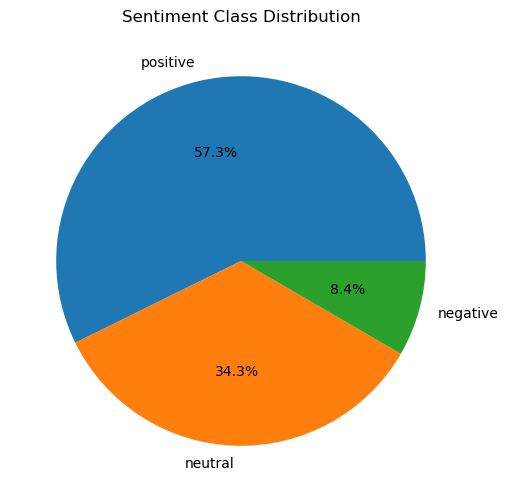

In [28]:
sentiment_dist = df['sentiments'].value_counts(normalize=True)
plt.figure(figsize=(8,6))
sentiment_dist.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Class Distribution')
plt.ylabel('')
plt.show()

Class imbalance evident with 58.8% positive reviews, meanwhile there is only 8.8% of negative ones which are relatively small compared to positive (58,8%) and neutral (36.3%).

As a result, we might consider apply SMOTE (synthetic Minority Over-sampling Technique) before training a model that can help it to learn classes equally to reduce overfitting risk.

### Review score distribution by sentiment


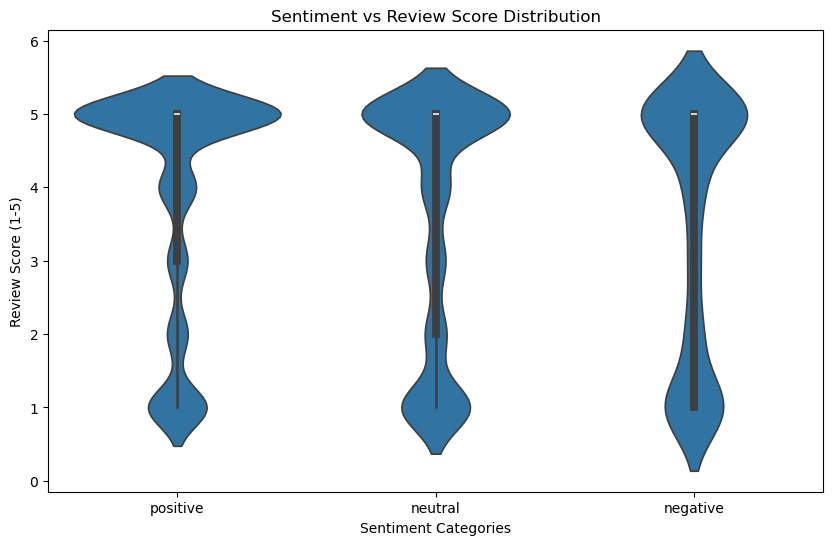

In [29]:
plt.figure(figsize=(10,6))
sns.violinplot(x=df["sentiments"], y=df["review_score"])
plt.title('Sentiment vs Review Score Distribution')
plt.xlabel('Sentiment Categories')
plt.ylabel('Review Score (1-5)')
plt.show()

From the plot above, we can see that:
* Higher scores (4-5) strongly correlate with positive sentiment
* Neutral reviews show wider score distribution

# 4. Text Analysis

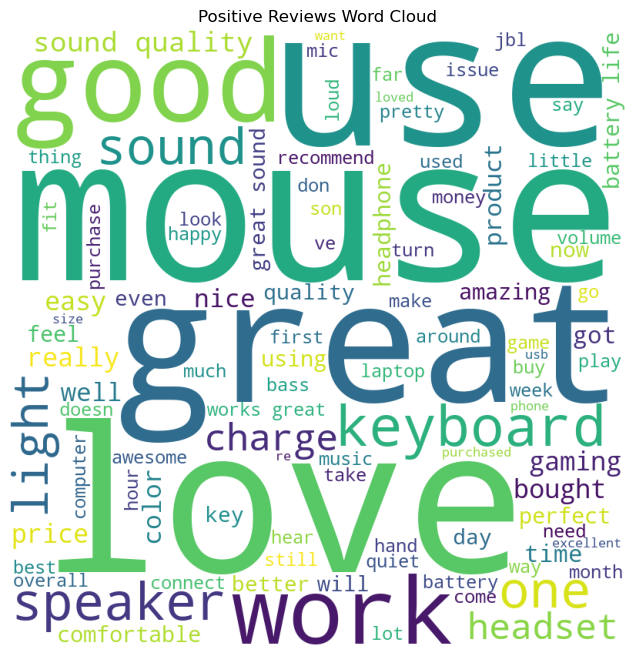

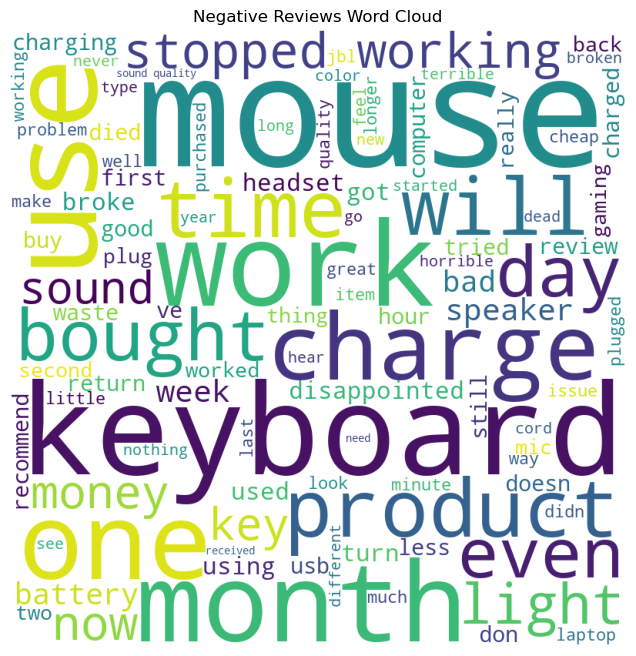

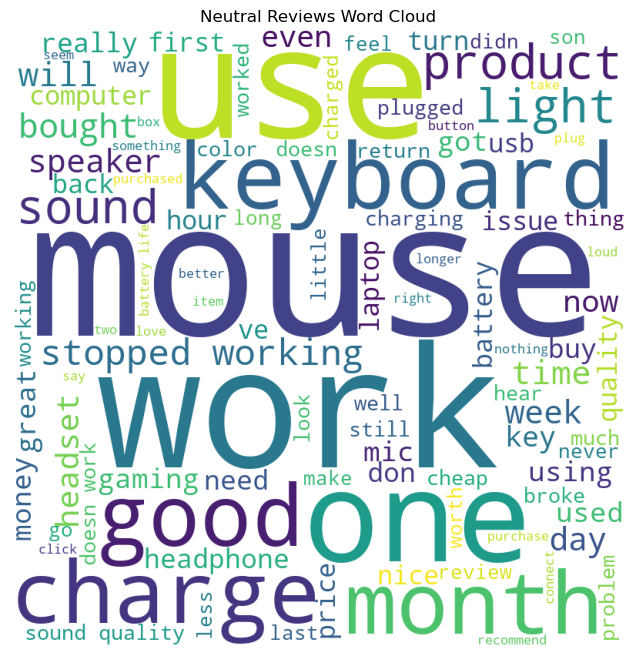

In [30]:
# Generate and display word cloud from text
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=STOPWORDS,
        max_words=100,
    ).generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
# Positive reviews word cloud
positive_text = ' '.join(df[df['sentiments'] == 'positive']['cleaned_review'])
generate_wordcloud(positive_text, 'Positive Reviews Word Cloud')

# Negative reviews word cloud
negative_text = ' '.join(df[df['sentiments'] == 'negative']['cleaned_review'])
generate_wordcloud(negative_text, 'Negative Reviews Word Cloud')

# Neutral reviews word cloud
neutral_text = ' '.join(df[df['sentiments'] == 'neutral']['cleaned_review'])
generate_wordcloud(neutral_text, 'Neutral Reviews Word Cloud')

**Insights:**
* Positive reviews emphasize: "mouse", "love", "great"
* Negative reviews highlight: "mouse", "keyboard", "work", "month"
* Neutral reviews show mixed terminology

However, since we're considering individual word without the context so it's hard to tell if these words reflex the sentiment of the product reviews correctly or not. It's better to consider two words or three words together (eg: quite good, not bad, ...) that has more meaning.

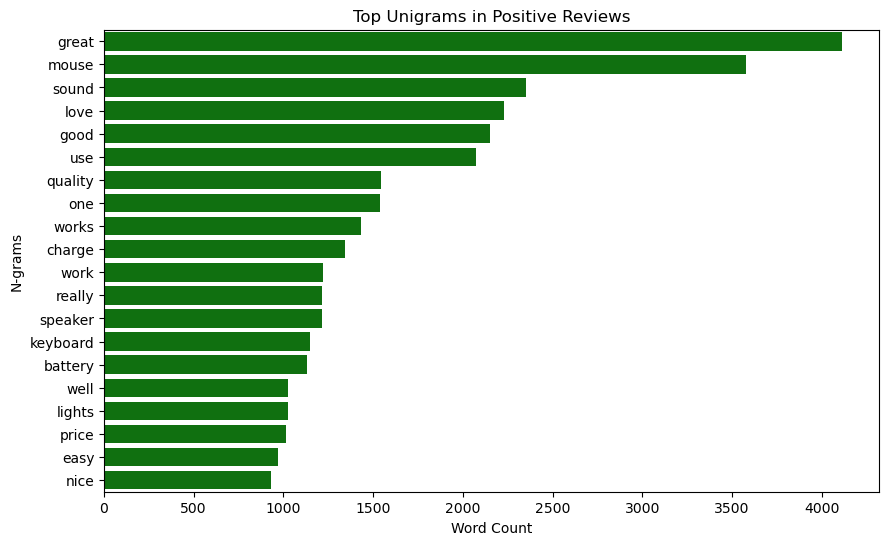

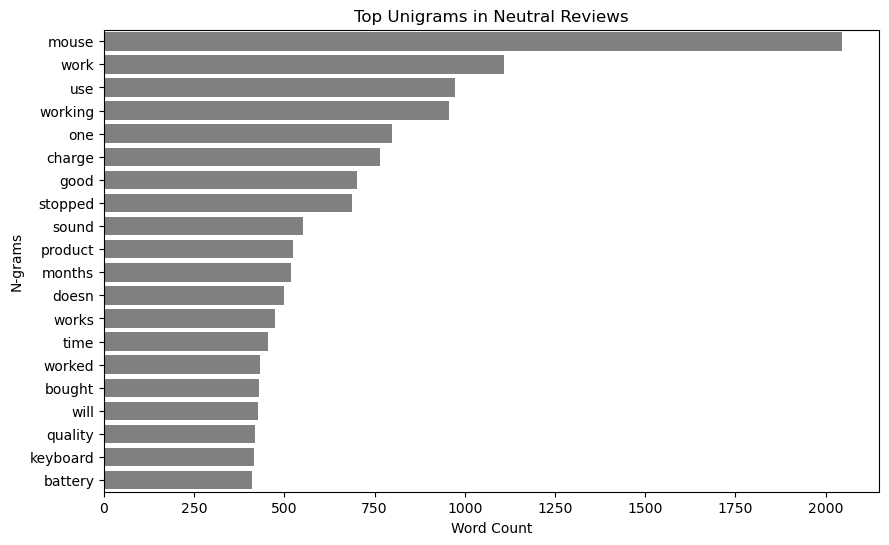

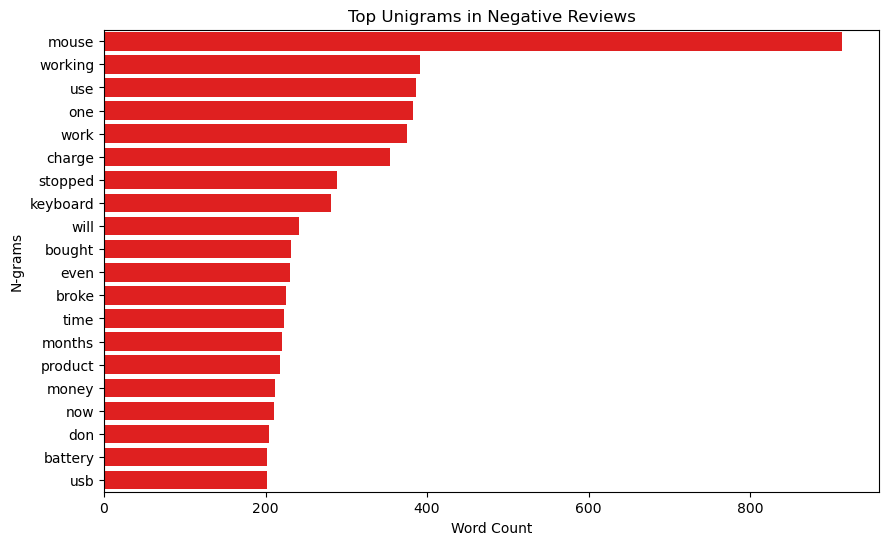

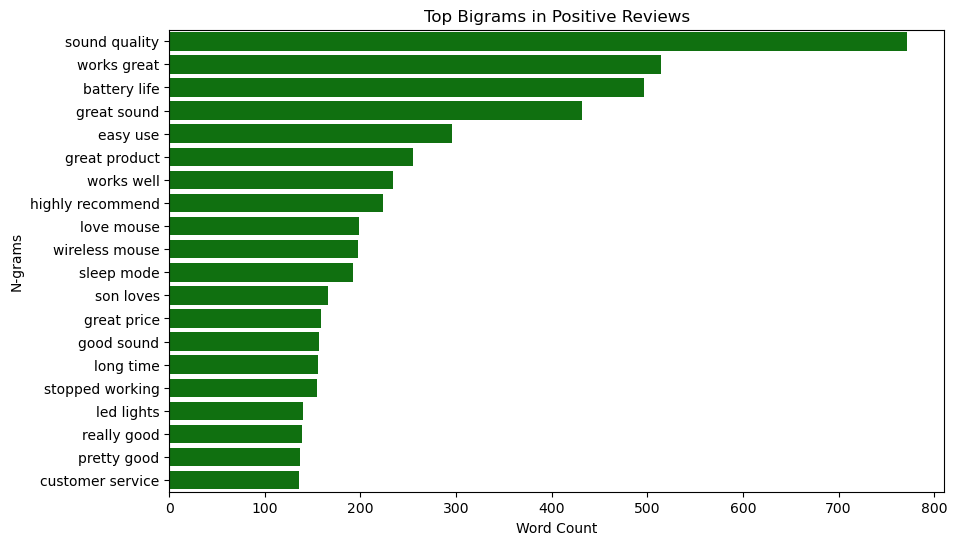

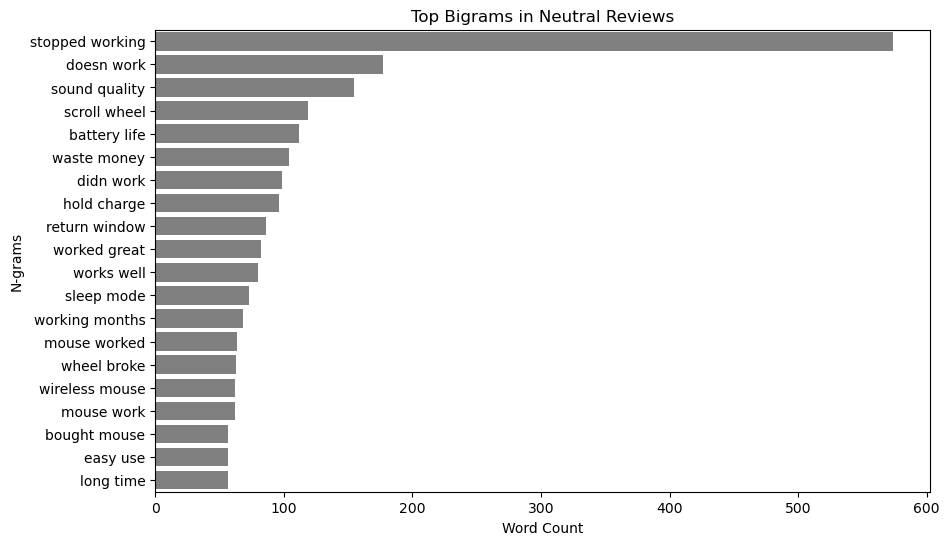

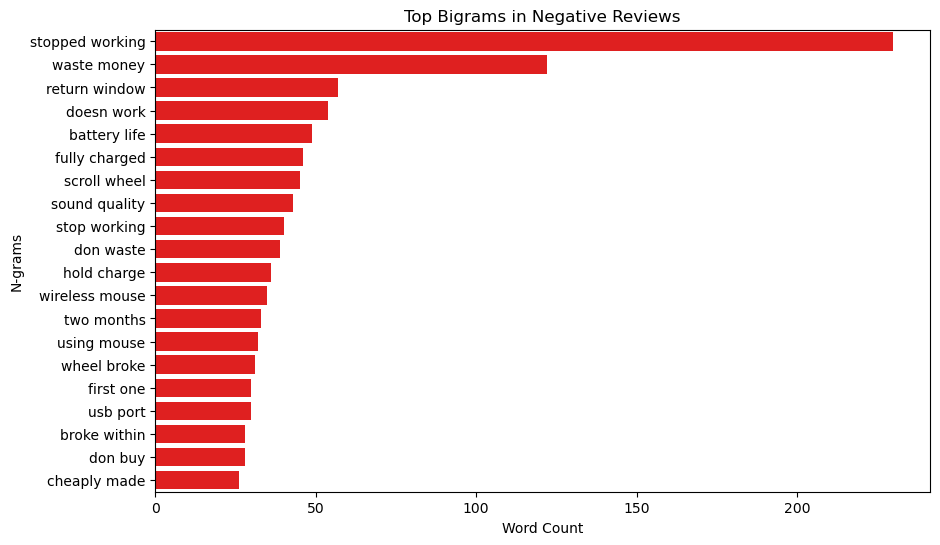

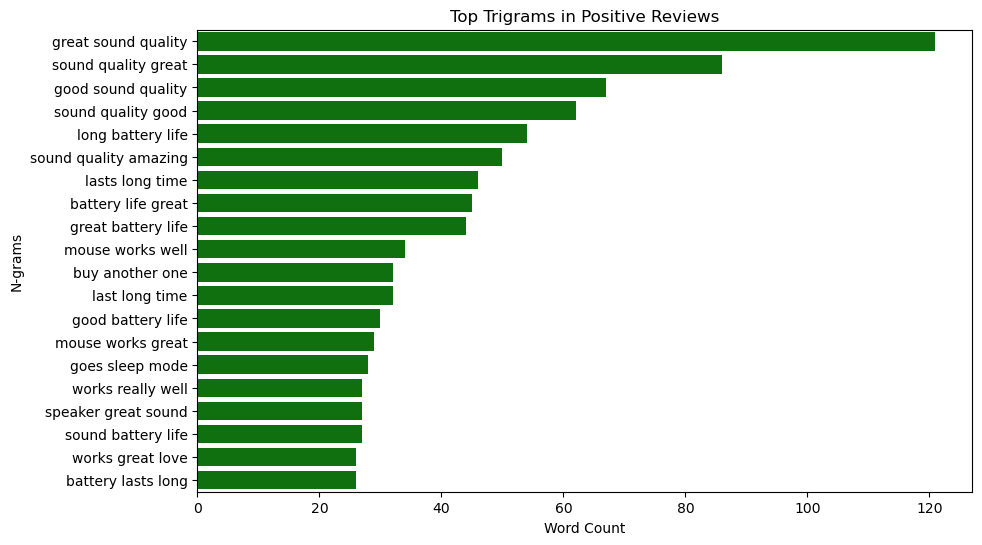

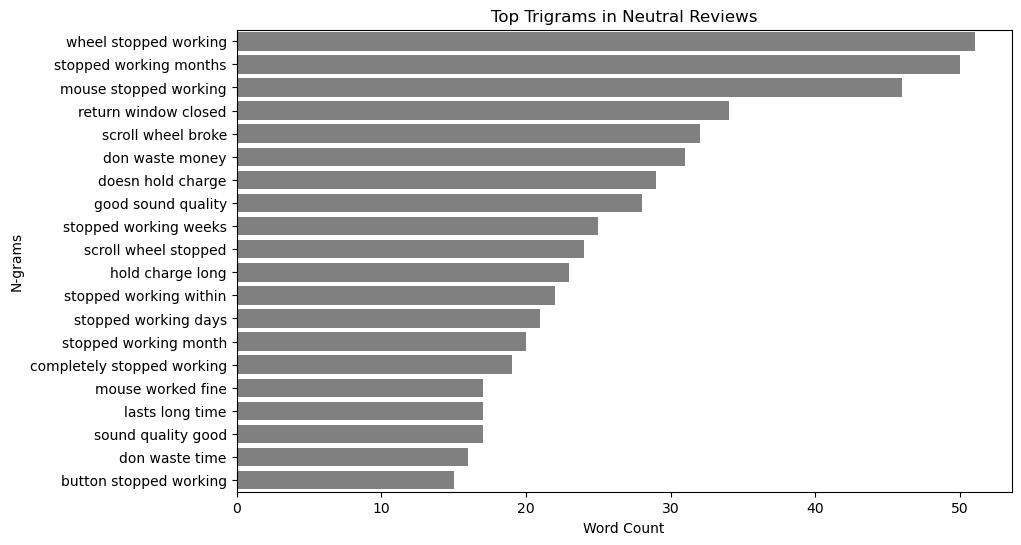

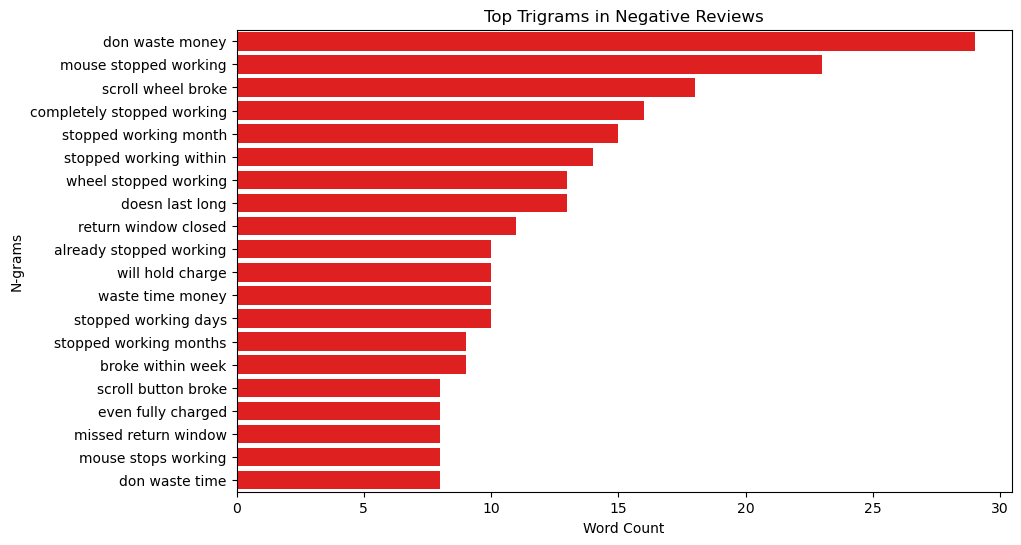

In [34]:
# code is taken from
# https://github.com/BenRoshan100/Sentiment-analysis-Amazon-reviews/blob/master/sentiment-analysis-amazon-reviews.ipynb
# and modified slightly by me

# Step 1: Filter the reviews by sentiment
review_pos = df[df["sentiments"].str.lower() == "positive"]
review_neu = df[df["sentiments"].str.lower() == "neutral"]
review_neg = df[df["sentiments"].str.lower() == "negative"]


# Step 2: Function to generate n-grams
def generate_ngrams(text, n_gram=1):
    tokens = [word for word in text.split() if word and word not in STOPWORDS]
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


# Step 3: Function to get top n-gram trace
def get_top_ngram_trace(reviews, n, head):
    freq_dict = defaultdict(int)
    for sent in reviews["cleaned_review"]:
        for ngram in generate_ngrams(sent, n_gram=n):
            freq_dict[ngram] += 1
    fd_sorted = pd.DataFrame(
        sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    )
    fd_sorted.columns = ["word", "wordcount"]
    return fd_sorted.head(head)


# Step 4: Plotting top n-grams for each sentiment
def plot_ngram_bars(data, title, color):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="wordcount", y="word", data=data, color=color)
    plt.title(title)
    plt.xlabel("Word Count")
    plt.ylabel("N-grams")
    plt.show()


# Step 5.1: Get top unigrams for each sentiment
top_pos_unigrams = get_top_ngram_trace(review_pos, n=1, head=20)
top_neu_unigrams = get_top_ngram_trace(review_neu, n=1, head=20)
top_neg_unigrams = get_top_ngram_trace(review_neg, n=1, head=20)

# Step 5.2: Get top bigrams for each sentiment
top_pos_bigrams = get_top_ngram_trace(review_pos, n=2, head=20)
top_neu_bigrams = get_top_ngram_trace(review_neu, n=2, head=20)
top_neg_bigrams = get_top_ngram_trace(review_neg, n=2, head=20)

# Step 5.3: Get top trigrams for each sentiment
top_pos_trigrams = get_top_ngram_trace(review_pos, n=3, head=20)
top_neu_trigrams = get_top_ngram_trace(review_neu, n=3, head=20)
top_neg_trigrams = get_top_ngram_trace(review_neg, n=3, head=20)

# Step 6: Plot each sentiment's n-grams
# 6.1: Unigrams
plot_ngram_bars(top_pos_unigrams, "Top Unigrams in Positive Reviews", "green")
plot_ngram_bars(top_neu_unigrams, "Top Unigrams in Neutral Reviews", "grey")
plot_ngram_bars(top_neg_unigrams, "Top Unigrams in Negative Reviews", "red")

# 6.2: Bigrams
plot_ngram_bars(top_pos_bigrams, "Top Bigrams in Positive Reviews", "green")
plot_ngram_bars(top_neu_bigrams, "Top Bigrams in Neutral Reviews", "grey")
plot_ngram_bars(top_neg_bigrams, "Top Bigrams in Negative Reviews", "red")

# 6.3: Trigrams
plot_ngram_bars(top_pos_trigrams, "Top Trigrams in Positive Reviews", "green")
plot_ngram_bars(top_neu_trigrams, "Top Trigrams in Neutral Reviews", "grey")
plot_ngram_bars(top_neg_trigrams, "Top Trigrams in Negative Reviews", "red")

As we can see:
* With unigram, most of top words (which appear the most in the reviews) such as mouse, working, etc can't reflex the sentiment in general.
* With Bigrams and Trigrams, it provides the context better that really help to identify sentiment better, so we can easily see some top word phases like don waste money (negative), mouse stopped working (negative), sounds quality (positive), work great (positive) exactly tell the sentiment of the reviews.

# Way 1: Use Multiple Layer Peceptron

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("amazon_reviews.csv")
# Remove rows where having null values
df = df.dropna()

# Encode labels
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["sentiments"])

# Split dataset into train and test sets
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label_encoded"], random_state=42
)

# Create pipeline to extract and build model
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MLPClassifier(max_iter=300, random_state=42, early_stopping=True)),
    ]
)

# Possible hyper-paramenters
param_grid = {
    "clf__hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "clf__activation": ["relu", "tanh"],
    "clf__solver": ["adam", "sgd"],
}

# Run grid search using list of possible hyper-paramenters using cross-validation technique to get the best model
grid = GridSearchCV(
    pipeline, param_grid, cv=5, n_jobs=-1, scoring="accuracy", verbose=2
)
grid.fit(train_val_df["cleaned_review"], train_val_df["label_encoded"])

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Use the best estimator (model) to make prediction on test set
best_model = grid.best_estimator_
test_preds = best_model.predict(test_df["cleaned_review"])

# Evaluate the model
print("\n=== Test Set Classification Report ===")
print(
    classification_report(
        test_df["label_encoded"], test_preds, target_names=label_encoder.classes_
    )
)


# Plot confusion matrix
def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_confusion(
    test_df["label_encoded"],
    test_preds,
    label_encoder.classes_,
    title="Test Confusion Matrix",
)

ConfusionMatrixDisplay.from_predictions(
    test_df["label_encoded"],
    test_preds,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    # normalize='true'
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (128, 64), 'clf__solver': 'adam'}
Best CV Score: 0.8260869565217391

=== Test Set Classification Report ===
              precision    recall  f1-score   support

    negative       0.80      0.55      0.65       307
     neutral       0.84      0.79      0.81      1260
    positive       0.87      0.94      0.90      1901

    accuracy                           0.85      3468
   macro avg       0.83      0.76      0.79      3468
weighted avg       0.85      0.85      0.85      3468



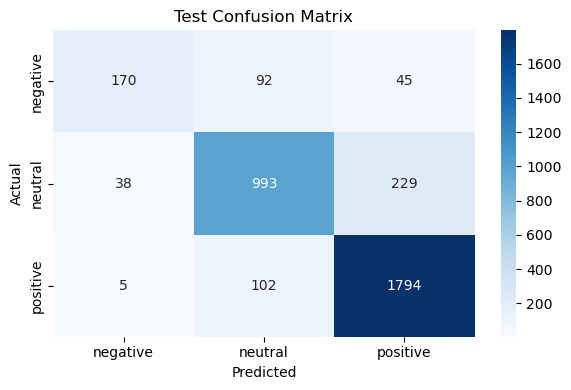

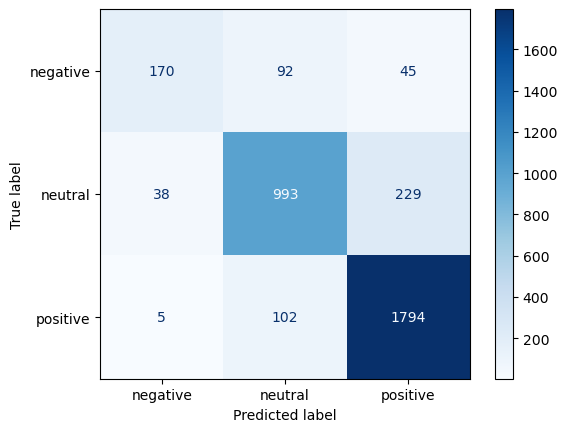

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("amazon_reviews.csv")
# Remove rows where having null values
df = df.dropna()

# Encode labels
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["sentiments"])

# Split dataset into train and test sets
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label_encoded"], random_state=42
)

# Create pipeline to extract and build model
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1, 2))),
        ("tfidf", TfidfTransformer()),
        ("clf", MLPClassifier(max_iter=100, random_state=42, early_stopping=True)),
    ]
)

# Possible hyper-paramenters
param_grid = {
    "clf__hidden_layer_sizes": [(128, 64)],
    "clf__activation": ["relu"],
    "clf__solver": ["adam"],
}

# Run grid search using list of possible hyper-paramenters using cross-validation technique to get the best model
grid = GridSearchCV(
    pipeline, param_grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=3
)
grid.fit(train_val_df["cleaned_review"], train_val_df["label_encoded"])

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Use the best estimator (model) to make prediction on test set
best_model = grid.best_estimator_
test_preds = best_model.predict(test_df["cleaned_review"])

# Evaluate the model
print("\n=== Test Set Classification Report ===")
print(
    classification_report(
        test_df["label_encoded"], test_preds, target_names=label_encoder.classes_
    )
)


# Plot confusion matrix
def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_confusion(
    test_df["label_encoded"],
    test_preds,
    label_encoder.classes_,
    title="Test Confusion Matrix",
)

ConfusionMatrixDisplay.from_predictions(
    test_df["label_encoded"],
    test_preds,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    # normalize='true'
)

# Way 2: Use Naive Bayes

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'clf__alpha': 0.5, 'clf__fit_prior': False}
Best CV Score: 0.7289628774325293

=== Test Set Classification Report ===
              precision    recall  f1-score   support

    negative       0.46      0.22      0.30       307
     neutral       0.65      0.66      0.65      1260
    positive       0.80      0.86      0.83      1901

    accuracy                           0.73      3468
   macro avg       0.64      0.58      0.60      3468
weighted avg       0.72      0.73      0.72      3468



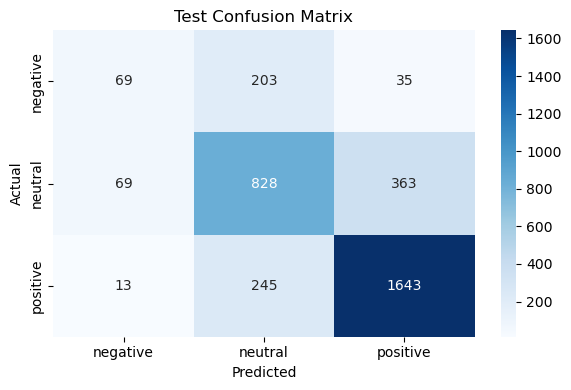

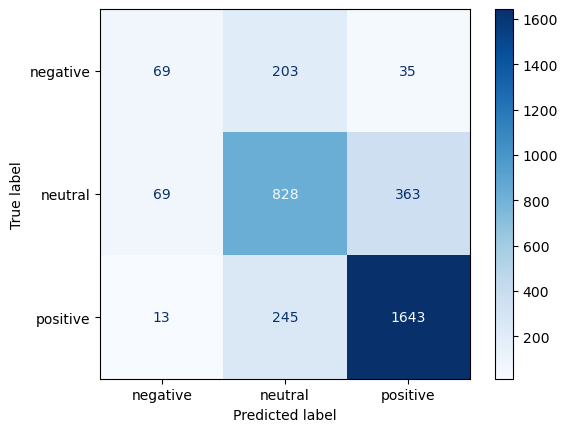

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('amazon_reviews.csv')
# Remove rows where having null values
df = df.dropna()
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiments'])
# Split dataset into train and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)
# Create pipeline to extract and build model
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])
# Possible hyper-paramenters
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
}
# Run grid search using list of possible hyper-paramenters using cross-validation technique to get the best model
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid.fit(train_val_df['cleaned_review'], train_val_df['label_encoded'])

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
# Use the best estimator (model) to make prediction on test set
best_model = grid.best_estimator_
test_preds = best_model.predict(test_df['cleaned_review'])
# Evaluate the model
print("\n=== Test Set Classification Report ===")
print(classification_report(test_df['label_encoded'], test_preds, target_names=label_encoder.classes_))
# Plot confusion matrix
def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_confusion(test_df['label_encoded'], test_preds, label_encoder.classes_, title="Test Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(
    test_df['label_encoded'],
    test_preds,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    # normalize='true'
)